# Pan Line 3 Coil Change Analysis

Dataset May 05, 2021 to December 02, 2025

1. Python configuration and requirements
   1. Create a Python virtual environment: `python3 -m venv ~/Python/venv/jupyter`
   2. Activate environment: `source ~/Python/venv/jupyter/bin/activate`
   3. Required packages are listed in _requirements.txt_ file
   4. Install required packages: `pip install -r requirements.txt`
2. Import Pan Line data and process: _data/Line 3 CoilUsage 2021_05_12-2025_12_02.csv_
   1. Set date data type for dates
   2. Extract year and day of year for production and load dates
   3. Extract stile gauge from Haas Smart Part Number
   4. Compare coil ID to previous to determine if the coil has changed
3. Create a data field with unique coils per day and coil changes per day


In [19]:
# CONSTANTS FOR STILE DIMENSIONS, WEIGHTS, AND COSTS
# END STILES AND CENTER STILES HAVE THE SAME DIMENSIONS AND WEIGHTS
# Length in inches
STILE_18_LENGTH = 18.196 
STILE_21_LENGTH = 21.196 
STILE_24_LENGTH = 24.196

# Weight in pounds
STILE_18_33_WEIGHT = 0.925
STILE_21_33_WEIGHT = 1.077 
STILE_24_33_WEIGHT = 1.230 

STILE_18_44_WEIGHT = 1.243 
STILE_21_44_WEIGHT = 1.448 
STILE_24_44_WEIGHT = 1.653 

STILE_18_55_WEIGHT = 1.547 
STILE_21_55_WEIGHT = 1.802 
STILE_24_55_WEIGHT = 2.057 

# Cost per pound in dollars
STILE_33_COST_PER_POUND =  0.5641
STILE_44_COST_PER_POUND =  0.5558 
STILE_55_COST_PER_POUND =  0.5549 


In [20]:
import pandas as pd
from IPython.display import Markdown as md

df = pd.read_csv('data/Line 3 CoilUsage 2021_05_12-2025_12_31.csv')

# # Set date type for date columns
df['DateTimeStamp'] = pd.to_datetime(df['DateTimeStamp'])
df['LoadDate'] = pd.to_datetime(df['LoadDate'])

# # Extract day of year and year from date columns
df['DayOfYear'] = df['DateTimeStamp'].dt.dayofyear
df['LoadDayOfYear'] = df['LoadDate'].dt.dayofyear
df['LoadYear'] = df['LoadDate'].dt.year
df['Year'] = df['DateTimeStamp'].dt.year
df['Month'] = df['DateTimeStamp'].dt.month

# # Make a column for the stile gauge
df['StileGauge'] = pd.to_numeric(df['SectionNumber'].str[12:13])

# # Make a copy of the CoilId column and shift down by one
# # then compare to see if the coil changed
df['IsCoilChange'] = df['HaasCoilNum'].shift(1) != df['HaasCoilNum']

# Get the 'Outside Panel Treatment' and 'Backer/Stile Placement Option' characters from the SectionNumber
df['StileCode'] = (df['SectionNumber'].str[8] + df['SectionNumber'].str[19]) + "-SS"

# Get the 'Section Height' from the SectionNumber
df['SectionHeight'] = pd.to_numeric(df['SectionNumber'].str[1:3])

# Get the 'Section Length' from the SectionNumber
df['SectionLength'] = pd.to_numeric(
    df['SectionNumber'].str[14:16]) * 12 + pd.to_numeric(df['SectionNumber'].str[16:18])

# Generate summary markdown
data_preview = f"""
### Data Preview
There are {len(df)} pan sections across {df['Year'].nunique()} years. Below is a table of the first five rows of the DataFrame:
{df.head(5).to_markdown(index=False)}
"""

display(md(data_preview))


### Data Preview
There are 1072558 pan sections across 5 years. Below is a table of the first five rows of the DataFrame:
| DateTimeStamp              | SectionNumber                  | HaasCoilNum                 | LoadDate            | IsCoilChange   |   DayOfYear |   LoadDayOfYear |   LoadYear |   Year |   Month |   StileGauge | StileCode   |   SectionHeight |   SectionLength |
|:---------------------------|:-------------------------------|:----------------------------|:--------------------|:---------------|------------:|----------------:|-----------:|-------:|--------:|-------------:|:------------|----------------:|----------------:|
| 2021-05-12 00:00:08.607000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | True           |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |
| 2021-05-12 00:00:35.673000 | B21PW-DBSS-N5-1000NS-NNNNN-NXL | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |
| 2021-05-12 00:01:03.290000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |
| 2021-05-12 00:01:31.227000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |
| 2021-05-12 00:01:58.243000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 | False          |         132 |             133 |       2021 |   2021 |       5 |            5 | SS-SS       |              21 |             120 |


### Coil Changes Per Day

#### How is it calculated?
- Since the boolean `IsCoilChange` is set to `True` each time the current coil is different from the previous, adding the `True` values for each day will reflect a daily coil-change count.
#### Potential issues
- In some cases Line 3 completes the sections for a given load date and starts working on another load date. When this happens a coil could be reloaded which would add coil changes to a work day making it seem less efficient. 

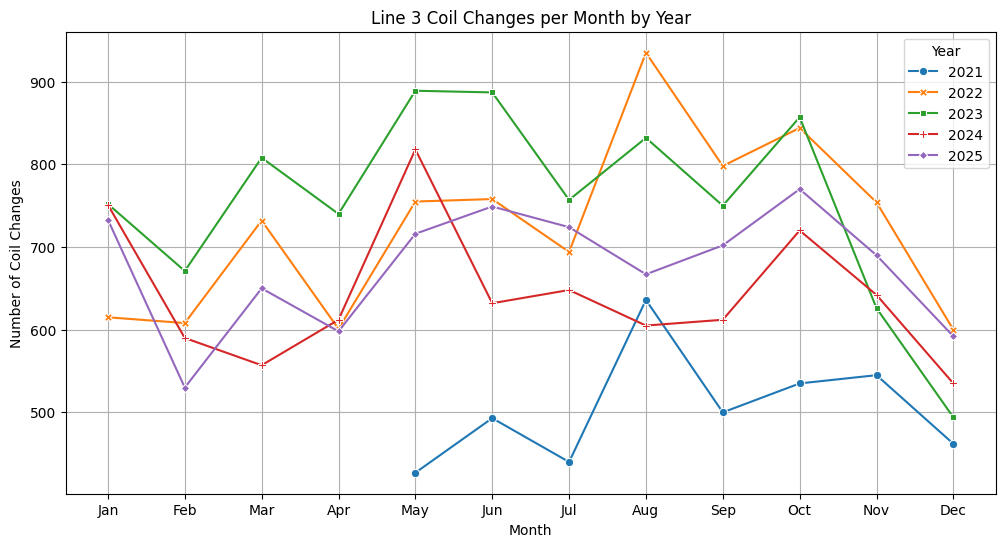

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of unique coils used per day of each year
unique_coils_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'HaasCoilNum'].nunique()

# Count the number of coils changed per day of each year
coils_changed_per_day_year = df.groupby(
    by=['Year', 'DayOfYear'], group_keys=True)['IsCoilChange'].sum()

# Merge the two series into the DataFrame
coil_changes_year = pd.merge(unique_coils_per_day_year, coils_changed_per_day_year, on=[
                             'Year', 'DayOfYear'], suffixes=('_UniqueCoils', '_CoilsChanged'))
coil_changes_year = coil_changes_year.rename(
    columns={'HaasCoilNum': 'Unique Coils', 'IsCoilChange': 'Coils Changed'})

# Create a dataframe showing the total coil changes per month for each year
coil_changes_month = df.groupby(by=['Year', 'Month'], group_keys=True)[
    'IsCoilChange'].sum().unstack(level=0)
coil_changes_month.index = coil_changes_month.index.map(
    lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

# display(md(coil_changes_month.to_markdown()))

# graph comparing years of coil changes per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=coil_changes_month, markers=True, dashes=False)
plt.title('Line 3 Coil Changes per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Coil Changes')
plt.legend(title='Year')
plt.grid()
plt.show()

### Planned Coil Changes

#### To estimate the minimum planned number of coil changes possible in a day, let's assume one load date per work day and find the unique combinations of stile gauges and coild IDs.

### Working Ahead?

#### How often does Line 3 get into the next load date?
- For every work day, let's calculate how many times Line 3 works on more than one load date
#### Qualify working ahead
- What circumstanses other than working ahead would cause the line to work on multiple load dates?
  - Section remakes
    - Let's assume that any work done for load dates earlier than the starting load date on a give work day are section remakes
  - Internal orders

In [22]:
# Count how many unique LoadDayOfYear there are for each DayOfYear per year
load_days_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'LoadDayOfYear'].nunique()

# display(md(load_days_per_day_year.unstack(level=0).to_markdown()))

# What is the average number of load days per day of year per year?
avg_load_days_per_day_year = load_days_per_day_year.groupby('Year').mean().round(2)
avg_load_days_per_day_year = avg_load_days_per_day_year.rename('Avg Load Days/Day')
display(md(avg_load_days_per_day_year.to_markdown()))

# Try to remove section remakes
# For each DayOfYear and Year, make a list of LoadDayOfYear values in order of appearance allowing
# values to be repeated but not consecutively
load_days_list_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'LoadDayOfYear'].apply(lambda x: [v for i, v in enumerate(x) if i == 0 or v != x.iloc[i-1]])

# Show as a markdown table
# display(md(load_days_list_per_day_year.unstack(level=0).to_markdown()))

load_days_list_per_day_year.unstack(level=0).to_excel('data/load_days_list_per_day_year.xlsx')


|   Year |   Avg Load Days/Day |
|-------:|--------------------:|
|   2021 |                2.69 |
|   2022 |                2.52 |
|   2023 |                2.83 |
|   2024 |                3.15 |
|   2025 |                3.55 |

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |    nan |    146 |    134 |    140 |    143 |
| Feb     |    nan |    144 |    133 |    120 |    117 |
| Mar     |    nan |    157 |    150 |    112 |    134 |
| Apr     |    nan |    144 |    142 |    118 |    129 |
| May     |    116 |    148 |    167 |    162 |    138 |
| Jun     |    113 |    155 |    153 |    134 |    146 |
| Jul     |    105 |    146 |    137 |    122 |    146 |
| Aug     |    153 |    164 |    149 |    139 |    135 |
| Sep     |    148 |    141 |    133 |    128 |    144 |
| Oct     |    115 |    158 |    156 |    150 |    149 |
| Nov     |    124 |    127 |    136 |    141 |    148 |
| Dec     |    120 |    123 |    117 |    122 |    124 |

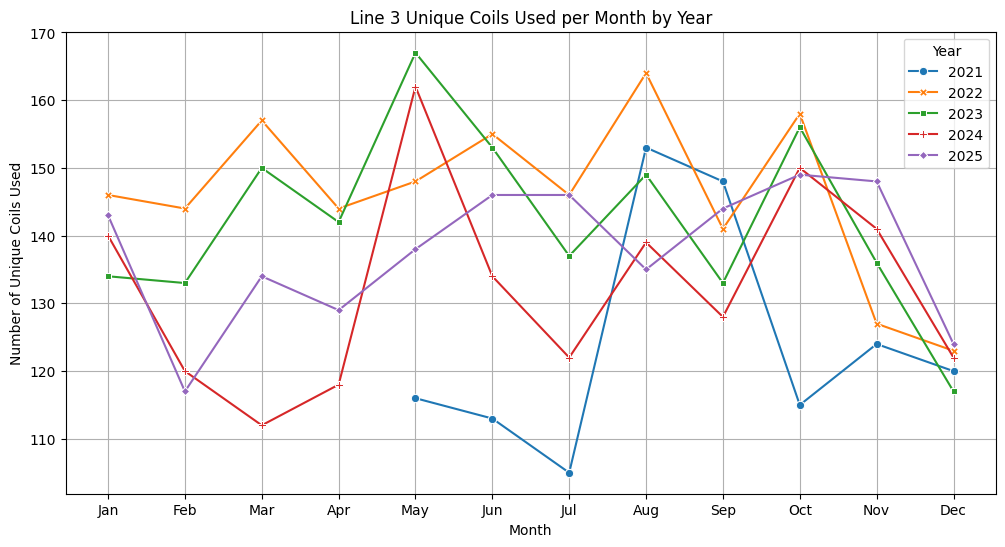

In [23]:
# Create a dataframe showing the number of unique coils used per month for each year
unique_coils_month = df.groupby(by=['Year', 'Month'], group_keys=True)[
    'HaasCoilNum'].nunique().unstack(level=0)
unique_coils_month.index = unique_coils_month.index.map(
    lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))
display(md(unique_coils_month.to_markdown()))
# graph comparing years of unique coils used per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=unique_coils_month, markers=True, dashes=False)
plt.title('Line 3 Unique Coils Used per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Unique Coils Used')
plt.legend(title='Year')
plt.grid()
plt.show()

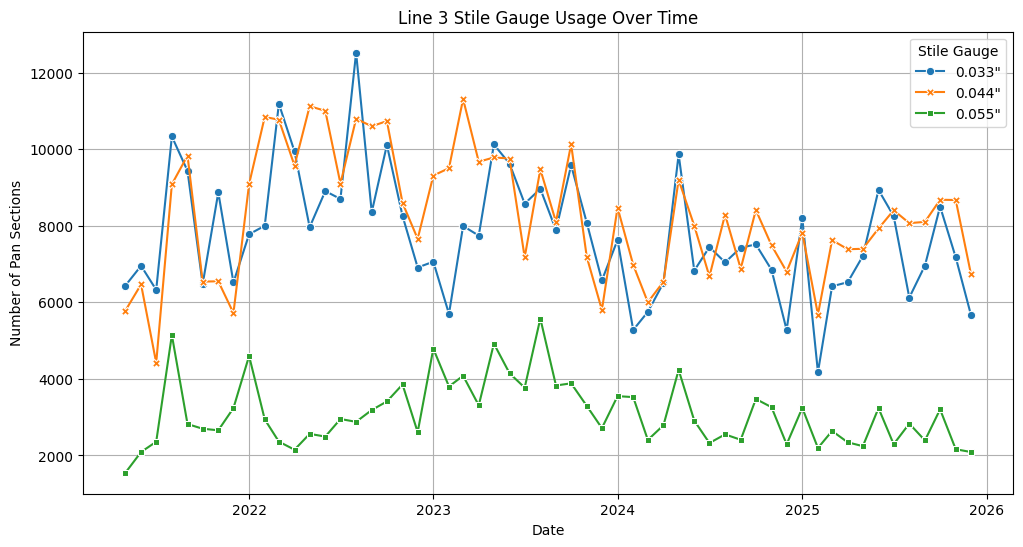

In [24]:
# Create a dataframe showing stile gauge usage over time from May 2021 to Dec 2025
stile_gauge_usage = df.groupby(by=['DateTimeStamp', 'StileGauge'], group_keys=True)[
    'SectionNumber'].count().unstack(level=1).fillna(0)
stile_gauge_usage = stile_gauge_usage.rename(columns=lambda x: f'0.0{x}{x}"')
stile_gauge_usage = stile_gauge_usage.resample('ME').sum()
stile_gauge_usage.index = stile_gauge_usage.index.to_period('M').to_timestamp()
# graph stile gauge usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_usage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Pan Sections')
plt.legend(title='Stile Gauge')
plt.grid()
plt.show()

StileGauge        0.033"     0.044"     0.055"
DateTimeStamp                                 
2021-05-01     46.747495  41.999419  11.253086
2021-06-01     44.824030  41.697821  13.478149
2021-07-01     48.275599  33.725011  17.999390
2021-08-01     42.063266  36.982453  20.954281
2021-09-01     42.713568  44.515370  12.771063


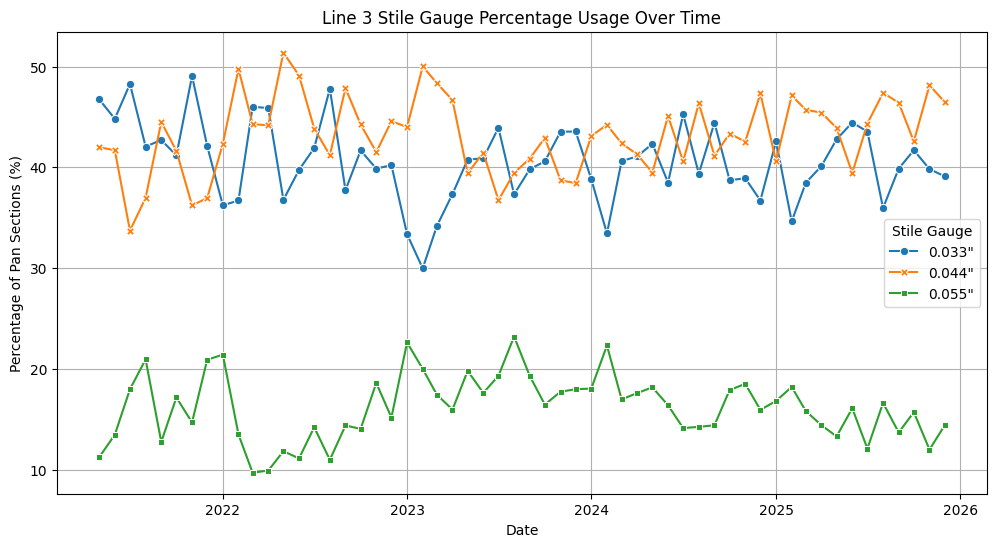

In [25]:
# Create a dataframe showing the percentage of stile gauge usage over time
stile_gauge_percentage = stile_gauge_usage.div(
    stile_gauge_usage.sum(axis=1), axis=0) * 100
print(stile_gauge_percentage.head())
# graph stile gauge percentage usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_percentage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Percentage Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Pan Sections (%)')
plt.legend(title='Stile Gauge')
plt.grid()
plt.show()

In [26]:
# Make a list of all the unique StileCodes
unique_stile_codes = df['StileCode'].unique()

print(f"Unique Stile Codes: {unique_stile_codes}")

# Check the file 'data/PANEL LOCATIONS (LINE 3) Rev 03_20.xlsx' to see if it
# has sheet name for each of the unique stile codes ex. 'BA-SS', 'BB-SS', etc.

# Create an ExcelFile object
xls_file = 'data/PANEL LOCATIONS (LINE 3) Rev 03_20.xlsx'
xls = pd.ExcelFile(xls_file)

# Get the list of sheet names
sheet_names = xls.sheet_names

# Create an empty dictionary to hold the data for each stile code
stile_dataframes = {}

# Make a list of orphan stile codes
orphan_stile_codes = []

# For each unique stile code, check if there is a corresponding sheet in the Excel file
# if there is, get the stile counts for each length and add to the stile dictionary
for stile_code in unique_stile_codes:
    if stile_code in sheet_names:
        # add the excel tab length/stile count data to the dictionary
        stile_dataframes[stile_code] = xls.parse(sheet_name=stile_code , usecols=[
                                                         2, 3], header=None, names=['Length', stile_code], skiprows=4)
        stile_dataframes[stile_code].set_index('Length', inplace=True)
    else:
        print(
            f"Sheet {stile_code} does NOT exist. Adding to orphan stile codes.")
        orphan_stile_codes.append(stile_code)

# Concatenate all the stile dataframes into a single stile key table
stile_key_table = pd.concat(stile_dataframes.values(), axis=1)

# Get all the rows from df where there is no corresponding stile code sheet
orphan_stile_df = df[df['StileCode'].isin(orphan_stile_codes)].copy()
orphan_stile_df.to_csv('data/orphan_stile_codes.csv', index=False)
print(f"There were {len(orphan_stile_df)} sections with orphan stile codes added to the report: 'data/orphan_stile_codes.csv.'")

Unique Stile Codes: ['SS-SS' 'SY-SS' 'SW-SS' 'CS-SS' 'NL-SS' 'BS-SS' 'NS-SS' 'NX-SS' 'N3-SS'
 'NW-SS' 'N2-SS' 'ND-SS' 'NA-SS' 'MS-SS' 'NC-SS' 'TS-SS' 'NF-SS' 'RS-SS'
 'NJ-SS' 'SA-SS' 'SD-SS' 'CW-SS' 'LS-SS' 'NY-SS' 'NZ-SS' 'CY-SS' 'UW-SS'
 'US-SS' 'BY-SS' 'BW-SS' 'SE-SS' 'RD-SS' 'SC-SS' 'BC-SS' 'NE-SS' 'CC-SS'
 'SX-SS' 'XS-SS' 'LW-SS' 'TW-SS' 'CD-SS' 'NM-SS' 'MY-SS' 'CE-SS' 'BD-SS'
 'CA-SS' 'UD-SS' 'NR-SS' 'MW-SS' 'N4-SS' 'UC-SS' 'NB-SS' 'BA-SS' 'N5-SS'
 'TY-SS' 'LY-SS' 'SJ-SS' 'MD-SS' 'UY-SS' 'TD-SS' 'NH-SS' 'GS-SS' 'TA-SS'
 'TC-SS' 'BE-SS' 'RW-SS' 'NK-SS' 'MC-SS' 'LD-SS' 'IF-SS' 'NV-SS' 'UA-SS'
 'DS-SS' 'N0-SS' 'N6-SS']
Sheet SJ-SS does NOT exist. Adding to orphan stile codes.
Sheet RW-SS does NOT exist. Adding to orphan stile codes.
There were 9 sections with orphan stile codes added to the report: 'data/orphan_stile_codes.csv.'


In [27]:
# Remove the rows with orphan stile codes from df
print(f"Dropping {len(orphan_stile_df)} rows with orphan stile codes from main dataframe.")
df = df[~df['StileCode'].isin(orphan_stile_codes)].copy()
# Make a new column for StileQuantity using the stile key table to look up the value based on SectionLength and StileCode
# Use datatype int for the StileQuantity column
df['StileQuantity'] = df.apply(lambda row: stile_key_table.at[row['SectionLength'], row['StileCode']], axis=1).fillna(0).astype(int)

df.to_csv('data/modified_coil_section_data.csv', index=False)

Dropping 9 rows with orphan stile codes from main dataframe.


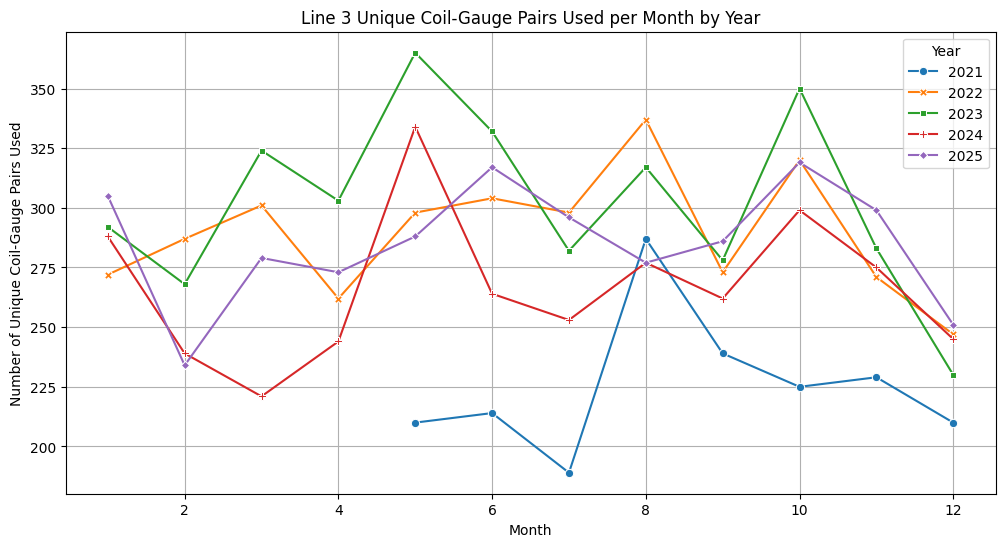

In [28]:
# Count the number of unique HaasCoilNum and StileGauge combinations used per day of each year
# Combine the two identifying columns into a single temporary column
df['CoilGaugePair'] = df['HaasCoilNum'].astype(str) + '_' + df['StileGauge'].astype(str)

# Group and count the unique values of the new combined column
unique_coil_gauge_per_day_year = df.groupby(['Year', 'DayOfYear'])['CoilGaugePair'].nunique().unstack(level=0)    

# # Display as markdown table
# display(md(unique_coil_gauge_per_day_year.to_markdown()))

# Create a dataframe showing the total unique coil-gauge pairs used per month for each year
unique_coil_gauge_per_month_year = df.groupby(by=['Year', 'Month'], group_keys=True)[
    'CoilGaugePair'].nunique().unstack(level=0)

# Remove the temporary column from the original dataframe
df = df.drop(columns=['CoilGaugePair'])

# Make a line plot comparing years of unique coil-gauge pairs used per month per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=unique_coil_gauge_per_month_year, markers=True, dashes=False)
plt.title('Line 3 Unique Coil-Gauge Pairs Used per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Unique Coil-Gauge Pairs Used')
plt.legend(title='Year')
plt.grid()
plt.show()

In [29]:
import itertools

# Make a list of the order of Stile Gauge used in order for each DayOfYear and Year
# Allow values to be repeated but not consecutively
# stile_gauge_list_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
#     'StileGauge'].apply(lambda x: [v for i, v in enumerate(x) if i == 0 or v != x.iloc[i-1]])

# Make a list of the order of Stile Gauge used in order for each DayOfYear and Year allowing duplicates
# Format the runs as (gauge, count) tuples
stile_gauge_list_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)[
    'StileGauge'].apply(list).apply(lambda x: [(gauge, sum(1 for _ in group)) for gauge, group in itertools.groupby(x)])


# display(md(stile_gauge_list_per_day_year.unstack(level=0).to_markdown()))
# stile_gauge_list_per_day_year.unstack(level=0).to_excel('data/stile_gauge_list_per_day_year2.xlsx')


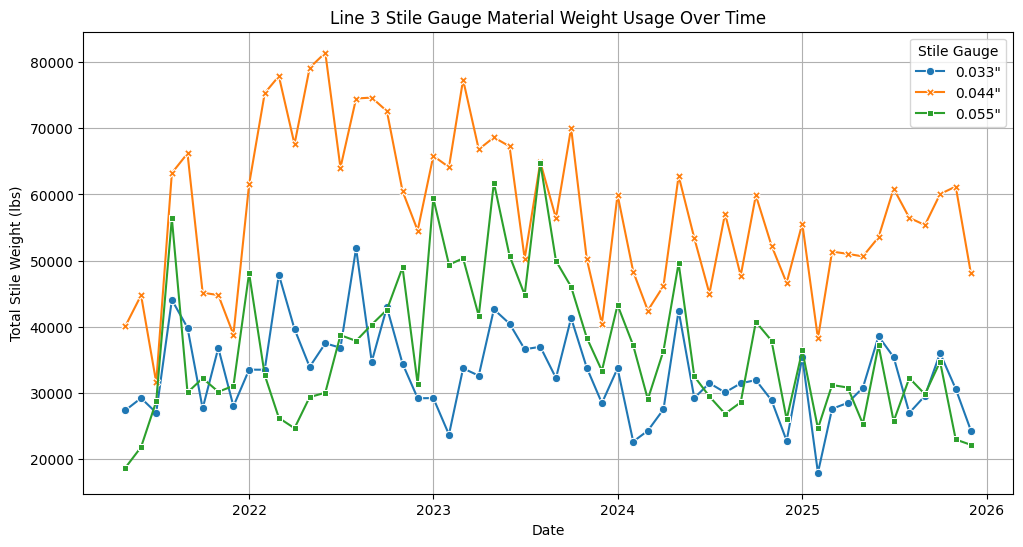

In [30]:
# Make a column for the weight of the stiles used in a section based on the StileGauge and SectionHeight
def calculate_stile_weight(row):
    gauge = row['StileGauge']
    height = row['SectionHeight']
    quantity = row['StileQuantity']
    
    if gauge == 3:
        if height == 18:
            weight_per_stile = STILE_18_33_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_33_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_33_WEIGHT
        else:
            weight_per_stile = 0
    elif gauge == 4:
        if height == 18:
            weight_per_stile = STILE_18_44_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_44_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_44_WEIGHT
        else:
            weight_per_stile = 0
    elif gauge == 5:
        if height == 18:
            weight_per_stile = STILE_18_55_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_55_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_55_WEIGHT
        else:
            weight_per_stile = 0
    else:
        weight_per_stile = 0
    
    total_weight = weight_per_stile * quantity
    return total_weight

df['StileWeight'] = df.apply(calculate_stile_weight, axis=1)
# Graph the total of each stile gauge weight per moth ofer the years
stile_weight_per_month = df.groupby(by=['DateTimeStamp', 'StileGauge'], group_keys=True)[
    'StileWeight'].sum().unstack(level=1).fillna(0)
stile_weight_per_month = stile_weight_per_month.rename(columns=lambda x: f'0.0{x}{x}"')
stile_weight_per_month = stile_weight_per_month.resample('ME').sum()
stile_weight_per_month.index = stile_weight_per_month.index.to_period('M').to_timestamp()
# graph stile weight usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_weight_per_month, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Material Weight Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Total Stile Weight (lbs)')
plt.legend(title='Stile Gauge')
plt.grid()
plt.show()

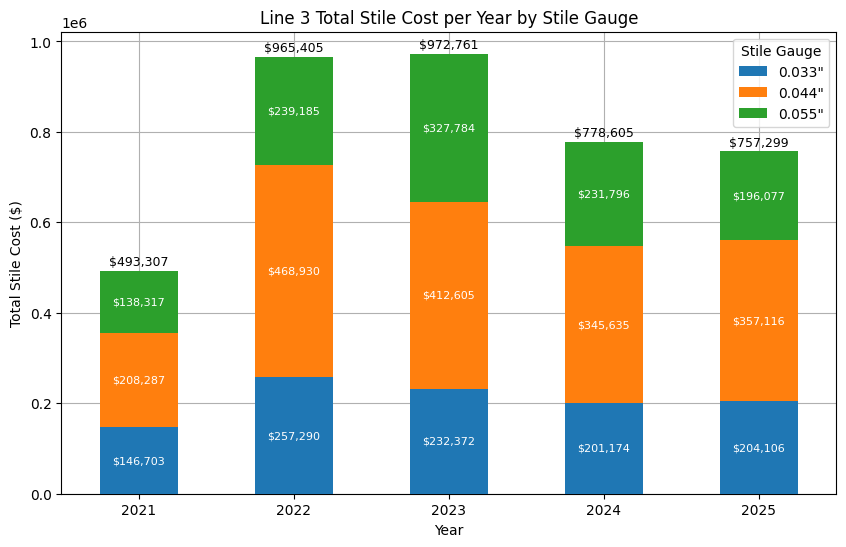

In [31]:
# Cost per year per stile gauge material weight
def calculate_stile_cost(row):
    gauge = row['StileGauge']
    weight = row['StileWeight']
    
    if gauge == 3:
        cost_per_pound = STILE_33_COST_PER_POUND 
    elif gauge == 4:
        cost_per_pound = STILE_44_COST_PER_POUND 
    elif gauge == 5:
        cost_per_pound = STILE_55_COST_PER_POUND 
    else:
        cost_per_pound = 0
    
    total_cost = cost_per_pound * weight
    return total_cost

df['StileCost'] = df.apply(calculate_stile_cost, axis=1)

# Create a stacked bar plot of total stile cost per year per stile gauge
stile_cost_per_year = df.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
stile_cost_per_year = stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Stile Gauge')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge')
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=0)
plt.show()

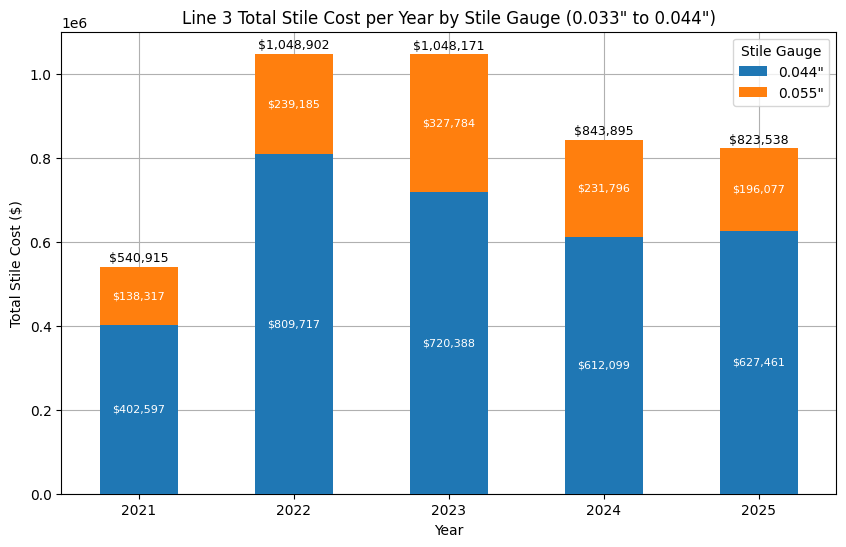

In [32]:
# Convert all the 3 gauge stiles to 4 gauge stiles and recalculate the stile weight and cost columns
def convert_3_to_4_gauge(row):
    gauge = row['StileGauge']
    height = row['SectionHeight']
    quantity = row['StileQuantity']
    
    if gauge == 3:
        # Convert to 4 gauge
        gauge = 4
    
    # Calculate the weight based on the new gauge
    if gauge == 4:
        if height == 18:
            weight_per_stile = STILE_18_44_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_44_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_44_WEIGHT
        else:
            weight_per_stile = 0
    elif gauge == 5:
        if height == 18:
            weight_per_stile = STILE_18_55_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_55_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_55_WEIGHT
        else:
            weight_per_stile = 0
    else:
        weight_per_stile = 0
    
    total_weight = weight_per_stile * quantity
    
    # Calculate the cost based on the new weight
    if gauge == 4:
        cost_per_pound = STILE_44_COST_PER_POUND 
    elif gauge == 5:
        cost_per_pound = STILE_55_COST_PER_POUND 
    else:
        cost_per_pound = 0
    
    total_cost = cost_per_pound * total_weight
    
    return pd.Series([gauge, total_weight, total_cost])

df_3to4 = df.copy()
df_3to4[['StileGauge', 'StileWeight', 'StileCost']] = df_3to4.apply(convert_3_to_4_gauge, axis=1)
# convert the stile gauge to an integer
df_3to4['StileGauge'] = df_3to4['StileGauge'].astype(int)   
# Create a stacked bar plot of total stile cost per year per stile gauge after conversion
# show the dollar amounts in the bars
converted_stile_cost_per_year = df_3to4.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
converted_stile_cost_per_year = converted_stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = converted_stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Stile Gauge (0.033" to 0.044")')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge') 
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(converted_stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=0)
plt.show()


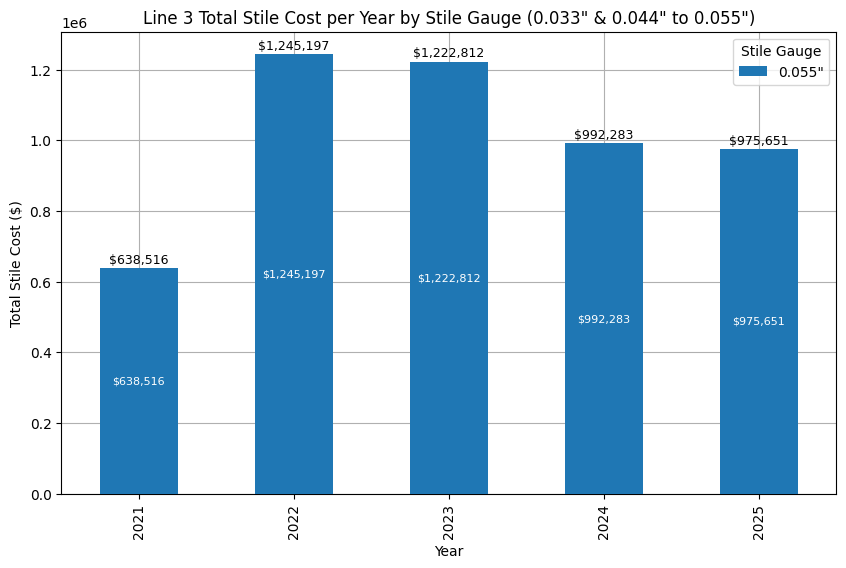

In [33]:
# Convert all the 3 and 4 gauge stiles to 5 gauge stiles and recalculate the stile weight and cost columns
def convert_3_to_4_gauge(row):
    gauge = row['StileGauge']
    height = row['SectionHeight']
    quantity = row['StileQuantity']
    
    if gauge == 3 or gauge == 4:
        # Convert to 5 gauge
        gauge = 5
    
    # Calculate the weight based on the new gauge
    if gauge == 5:
        if height == 18:
            weight_per_stile = STILE_18_55_WEIGHT
        elif height == 21:
            weight_per_stile = STILE_21_55_WEIGHT
        elif height == 24:
            weight_per_stile = STILE_24_55_WEIGHT
        else:
            weight_per_stile = 0
    else:
        weight_per_stile = 0
    
    total_weight = weight_per_stile * quantity
    
    # Calculate the cost based on the new weight
    if gauge == 5:
        cost_per_pound = STILE_55_COST_PER_POUND 
    else:
        cost_per_pound = 0
    
    total_cost = cost_per_pound * total_weight
    
    return pd.Series([gauge, total_weight, total_cost])

df_3and4to5= df.copy()
df_3and4to5[['StileGauge', 'StileWeight', 'StileCost']] = df_3and4to5.apply(convert_3_to_4_gauge, axis=1)
# convert the stile gauge to an integer
df_3and4to5['StileGauge'] = df_3and4to5['StileGauge'].astype(int)   
# Create a stacked bar plot of total stile cost per year per stile gauge after conversion
# show the dollar amounts in the bars
converted_stile_cost_per_year = df_3and4to5.groupby(by=['Year', 'StileGauge'], group_keys=True)[
    'StileCost'].sum().unstack(level=1).fillna(0)
converted_stile_cost_per_year = converted_stile_cost_per_year.rename(columns=lambda x: f'0.0{x}{x}"')
ax = converted_stile_cost_per_year.plot(kind='bar', stacked=True, zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Stile Gauge (0.033" & 0.044" to 0.055")')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Stile Gauge') 
plt.grid()
# Add dollar amounts on top of each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white')
# Add the column totals above the bars
for i, total in enumerate(converted_stile_cost_per_year.sum(axis=1)):
    ax.text(i, total + 5000, f'${total:,.0f}', ha='center', va='bottom', fontsize=9)
plt.show()

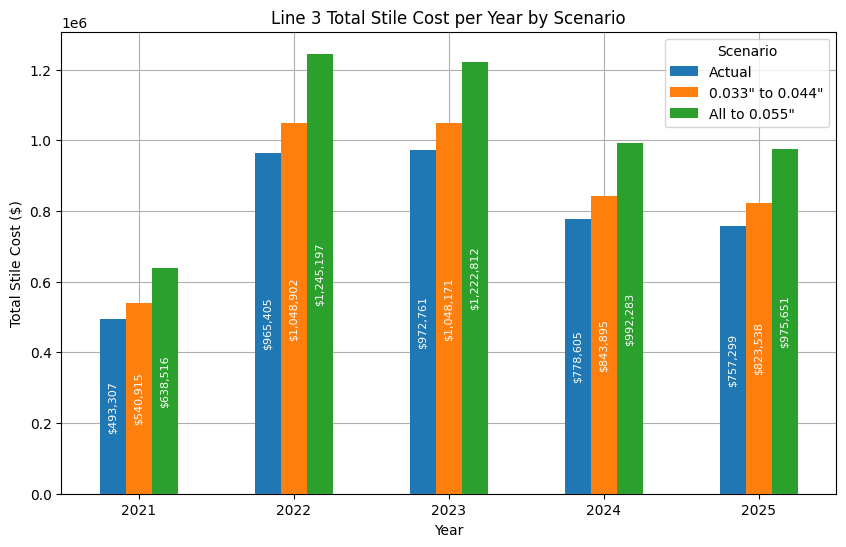

In [34]:
# Compare the total costs for each scenario for each year
total_cost_comparison = pd.DataFrame({
    'Actual': stile_cost_per_year.sum(axis=1),
    '0.033" to 0.044"': df_3to4.groupby(by=['Year'])['StileCost'].sum(),
    'All to 0.055"': df_3and4to5.groupby(by=['Year'])['StileCost'].sum()
})

# Graph the total costs for each scenario for each year
ax = total_cost_comparison.plot(kind='bar', zorder=3, figsize=(10, 6))
plt.title('Line 3 Total Stile Cost per Year by Scenario')
plt.xlabel('Year')
plt.ylabel('Total Stile Cost ($)')
plt.legend(title='Scenario')
plt.grid()
# Add dollar to teh center of each bar segment and rotate the dollar amounts for better readability
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width/2, y + height/2, f'${height:,.0f}', ha='center', va='center', fontsize=8, color='white', rotation=90)
plt.xticks(rotation=0)
plt.show()
